# Physiology data

Load data and example plots

This notebook shows how to read data from npz files and plot population responses

#### from: Goldbach, Akitake, Leedy, Histed, "Performance in even a simple perceptual task depends on mouse secondary visual areas"

------------





In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from pathlib import Path

import pytoolsMH as ptMH # utils, clone from: https://github.com/histed/PyToolsMH

a_ = np.asarray
r_ = np.r_

# Plotting setup
sns.set_style('ticks')
sns.set_context('paper')

## Load physiology datafiles 

In [2]:
# Load npz physiology data files
data_dir = Path('../data').resolve()

file_list = ['phys_outV1.npz', 'phys_outLM_dLM.npz', 'phys_outPM_dPM.npz', 'phys_outLM_V1f.npz', 'phys_outPM_V1f.npz', 'phys_outLM.npz', 'phys_outPM.npz' ]
data_dict = {}

for (iO,tO) in enumerate (file_list):
    npzfile = np.load(data_dir / tO)
    meanMat = npzfile['meanMat']
    semMat = npzfile['semMat']
    xv = npzfile['xv']
    unqPowers = npzfile['unqPowers']
    offsets = npzfile['offsets']
    SelUnits = npzfile['SelUnits']
    
    ds = pd.Series({'meanMat': meanMat, 'semMat': semMat, 'xv':xv, 'unqPowers': unqPowers,'SelUnits': SelUnits, 'offsets': offsets})
    data_dict.update({tO: ds})

# Population physiology responses - Figure 5

In the panel below, change the variable in npzfile, to read in data from different physiology analyses.

Direct inhibtion of V1, LM, or PM while recording in the same area:
* phys_outV1.npz 
* phys_outLM_dLM.npz 
* phys_outPM_dPM.npz

Feedforward inhibition of V1 while recording in LM or PM:
* phys_outLM_V1f.npz
* phys_outPM_V1f.npz

Feedback, effects of HVA inhibition while recording in V1"
* phys_outLM.npz
* phys_outPM.npz

Plots show  in the visual response window. Colorbar labels are mW/mm2. These data are used for Figure 5. 


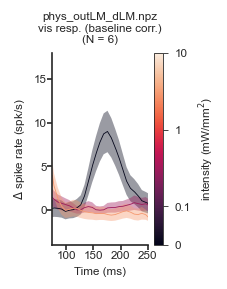

In [7]:
# Load npz physiology data file from data_dict - Change file to view different analyses (see above)
# Direct inhibition of LM during with recording in LM shown as an example.
npzfile_name = 'phys_outLM_dLM.npz'
npzfile = data_dict[npzfile_name]

fig, ax = plt.subplots(figsize=r_[2,2.5], dpi=120) 

# Color bar plotting
cbarPowers = npzfile['unqPowers']
lowOffP = 0
cbarPowers[cbarPowers==0] = 10**-1.5  # set zero power at a fixed offset
logP = np.log10(cbarPowers)

# Construct a mappable that converts log inputs to colors, with specified clim
nMapC = 256
clim = r_[-1.5,1]
smap = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=clim[0], vmax=clim[1]), cmap='rocket')

# Create plots with available stimulation power levels
for (iP, tP) in enumerate(npzfile['unqPowers']):
        tV = npzfile.meanMat[iP]
        sem = npzfile.semMat[iP]
        
        # Set the amount of smoothing with sspan
        tV = ptMH.math.smooth_lowess(tV, span = 35)      
        sem = ptMH.math.smooth_lowess(sem, span = 35)

        tLogPow = logP[iP]
        powerPct = (tLogPow - np.min(clim) + lowOffP) / np.diff(clim)
        cmapN = int(powerPct * 255) # map to an index 0..255 for use indexing into colormap

        ax.plot(npzfile.xv, tV + npzfile.offsets[iP], linewidth = 0.5, label=tP, color=smap.to_rgba(tLogPow))
        ax.fill_between(npzfile.xv, (tV + npzfile.offsets[iP]) + sem, (tV + npzfile.offsets[iP])-sem, alpha=0.4, linewidth = 0, color=smap.to_rgba(tLogPow))
        
# Create colorbar
yts = r_[logP[0],-1,0,1]
cbh = plt.colorbar(smap, ticks = yts) # set ticks on colorbar here
labs = ['%g'%x for x in np.hstack((0,10**yts[1:]))] # force y tick labels
cbh.outline.set_linewidth(0.5)
cbh.ax.tick_params(axis='both', width = 0.5, length = 3)
cbh.ax.set_yticklabels(labs,fontsize = 7)
cbh.set_label('intensity (mW/mm$^2$)', fontsize=7)

# Adjust plot parameters
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title(npzfile_name + '\n' + 'vis resp. (baseline corr.)' + '\n' + '(N = ' + str(npzfile.SelUnits) +')', fontsize = 7)
ax.set_ylabel('$\Delta$ spike rate (spk/s)', fontsize = 7)
ax.set_xlabel('Time (ms)', fontsize = 7)
ax.set_ylim([-4,18])
ax.set_xlim([75,250])
ax.set_xticks([100, 150, 200, 250])
ax.tick_params(axis='x',labelsize=7, pad=0.4, length=3)
ax.tick_params(axis='y',labelsize=7, pad=0.4, length=3)

plt.tight_layout()